<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/04_DefineFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install the Hijri converter package (if not installed)

In [ ]:
!pip install hijri-converter

In [2]:
import pandas as pd
import glob
import numpy as np
from hijri_converter import Hijri, Gregorian
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

**Read the data files**


*   Define correct seperator, tab in our example
*   Use dtype to enforce data type mainy in casefield field has mix data types
*   Use low_memory=False so you do not mind whatever type the undefined fields are read in they have mix data





In [3]:
pathData = "/content/drive/MyDrive/ColabNotebooks/dataset/02_ProcessedData/"
pathExternal = "/content/drive/MyDrive/ColabNotebooks/dataset/03_ExternalData/"


In [5]:
with open(pathData + 'data.pk', 'rb') as f:
  df = pickle.load(f)
print("number of records:", len(df))

number of records: 5241015


In [ ]:
import hashlib

def hashSKU(s):  
      return int(hashlib.sha1(s.encode("utf-8")).hexdigest(), 16) % (10 ** 8)

Test some data to ensure everything is read correctly

**Feature Creation**

In [ ]:
from hijri_converter import Hijri, Gregorian

def hijriDate(row):  
    y = row['DATE1'].year
    m = row['DATE1'].month
    d = row['DATE1'].day
    return Gregorian(y, m, d).to_hijri()

def isRamadan(dt):  
    if dt.month == 9:
      return 1
    else:
      return 0

def isRamadanEnd(dt):  
    if dt.month == 9 and dt.day >= 21:
      return 1
    else:
      return 0

def isEid(dt):  
    if (dt.month == 10 and dt.day < 4) or (dt.month == 12 and dt.day < 9 and dt.day > 14):
      return 1
    else:
      return 0

In [ ]:
def isWeekend(dt):  
    if dt.weekday() == 4 or dt.weekday() == 5: # Monday is 0
      return 1
    else:
      return 0

def isSalaryweek(dt):  
    if dt.day >= 25:
      return 1
    else:
      return 0

def isNationalday(dt):  
    if (dt.month == 2 and dt.day == 22) or (dt.month == 9 and dt.day == 23) :
      return 1
    else:
      return 0

Convert DATE1 from string to date format

In [ ]:
df['DATE1'] = pd.to_datetime(df['DATE1'], format='%Y-%m-%d %H:%M:%S')

**Date static features, convert date to features**

If DATE1 is indexed then use the below instead of the above

In [ ]:
df['hashedSKU'] = df['ITEM_ID'].apply(lambda s: hashSKU(s))

In [ ]:
df = df.drop(columns=['ITEM_ID'])

In [ ]:
df['dayofyear'] = df['DATE1'].apply(lambda dt: dt.dayofyear)
df['Monthday'] = df['DATE1'].apply(lambda dt: dt.day)
df['Weekday'] = df['DATE1'].apply(lambda dt: dt.dayofweek)
df['weekofyear'] = df['DATE1'].apply(lambda dt: dt.week)
df['month'] = df['DATE1'].apply(lambda dt: dt.month)
df['quarter'] = df['DATE1'].apply(lambda dt: dt.quarter)

Assign features related to calendar DATE1

In [ ]:
df['isSalaryweek'] = df['DATE1'].apply(lambda dt: isSalaryweek(dt))
df['isWeekend'] = df['DATE1'].apply(lambda dt: isWeekend(dt))
df['isNationalday'] = df['DATE1'].apply(lambda dt: isNationalday(dt))

In [ ]:
df['hijri'] = df.apply(lambda row: hijriDate(row), axis=1)
df['isRamadan'] = df['hijri'].apply(lambda dt: isRamadan(dt))
df['isRamadanEnd'] = df['hijri'].apply(lambda dt: isRamadanEnd(dt))
df['isEid'] = df['hijri'].apply(lambda dt: isEid(dt))

In [ ]:
df = df.drop(columns=['hijri'])

Import school days and calendar related activities that could impact all items and sales centers and add them to the features dataframe

In [ ]:
calenderFeatures = pd.read_csv(pathExternal +'calenderFeatures.csv', sep=',', lineterminator='\r', low_memory=False)
calenderFeatures = calenderFeatures.replace('\n','', regex=True)
calenderFeatures['DATE1'] = pd.to_datetime(calenderFeatures['DATE1'], format='%Y-%m-%d %H:%M:%S')
df = pd.merge(df, 
              calenderFeatures, 
              on =['DATE1'], 
              how ='inner')

In [ ]:
df = df.drop(columns=['TTL_VAL', 'TTL_CST'])

In [ ]:
Categories = pd.read_csv(pathExternal +'Categories.csv', sep=',', lineterminator='\r', low_memory=False)
Categories = Categories.replace('\n','', regex=True)
Categories[['CL_1']] = Categories[['CL_1']].astype(float, errors = 'raise')
Categories = Categories[['CL_1','Category']]
Categories = Categories.reset_index()
Categories = Categories.drop(columns=['index'])
Categories = Categories.dropna(subset=['Category']) 
Categories.dtypes

Add SKU category

Read and clean categories file

In [ ]:
SKUcategory = pd.read_csv(pathExternal +'ITEMS_MASTER.csv', sep='\t', lineterminator='\r', low_memory=False)
SKUcategory = SKUcategory.replace('\n','', regex=True)
SKUcategory[['ITEM_ID']] = SKUcategory[['ITEM_ID']].astype(str, errors = 'raise')
SKUcategory = SKUcategory.reset_index()
SKUcategory = SKUcategory.drop(columns=['index'])
SKUcategory = pd.merge(SKUcategory, 
              Categories, 
              on =['CL_1'], 
              how ='inner')
SKUcategory = SKUcategory[['ITEM_ID','Category']]
SKUcategory.dtypes

In [ ]:
oneHot = (pd.get_dummies(SKUcategory.Category, prefix='Category').reset_index())
SKUcategory = SKUcategory.join(oneHot)
SKUcategory = SKUcategory.drop(columns=['Category', 'index'])

In [ ]:
SKUcategory['hashedSKU'] = SKUcategory['ITEM_ID'].apply(lambda s: hashSKU(s))

In [ ]:
SKUcategory = SKUcategory.drop(columns=['ITEM_ID'])

In [ ]:
df = pd.merge(df, 
              SKUcategory, 
              on =['hashedSKU'], 
              how ='inner')

In [ ]:
FEATURES = list(df.columns.values)
print('number of features:', len(FEATURES))
FEATURES

In [ ]:
df.info()

As all field should be either numerical or boolean and string is not accepted, we are running the model for one SKU only, filtering the dataframe where ITEM_ID is matching with the SKU code, and drop all others

In [ ]:
with open(pathData + 'model.pk', 'wb') as f:
  pickle.dump(df, f)

In [ ]:
df124766 = df.query(f'hashedSKU == {hashSKU("124766")}')

In [ ]:
with open(pathData + '124766.pk', 'wb') as f:
  pickle.dump(df124766, f)

**Below to be implemented in the future**

Import selective days and calendar related activities that could impact selective items and sales centers and add them to the features dataframe

In [ ]:
df.set_index("DATE1", inplace = True)

**Visualize our Feature / Target Relationship**

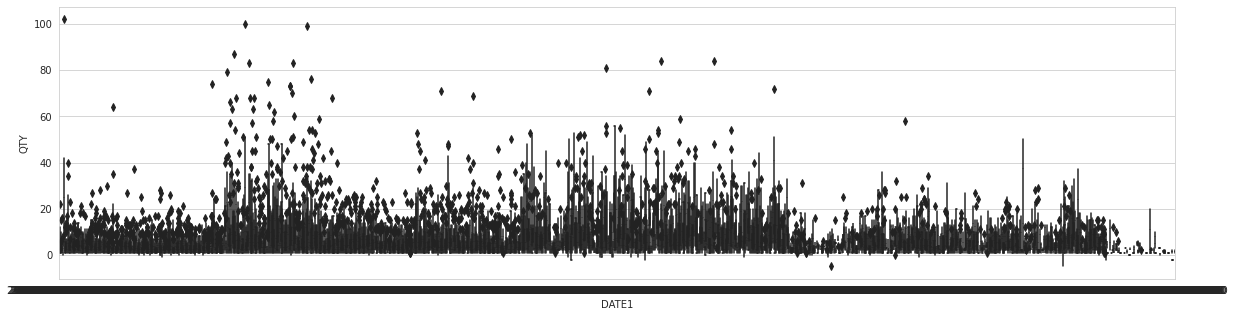

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [20, 5] #  [width, height]  
sns.boxplot(x = df.index.get_level_values('DATE1'),  # ('SLS_CNTR_ID')
            y = 'QTY',
            data = df, palette="Blues", width=0.3)